# Exercise 1
Calculate the convolution of the following 4x4 matrix and the 2x2 filter:

Given matrix $A$:
\begin{bmatrix}
     2 &  5 & -3 &  0 \\
     0 &  6 &  0 & -4 \\
    -1 & -3 &  0 &  2 \\
     5 &  0 &  0 &  3 \\
\end{bmatrix}

Filter $F$:
\begin{bmatrix}
    -2 & 0 \\
     4 & 6 \\
\end{bmatrix}

## By hand

1. Top-left corner (0,0):
   $(2 \times -2) + (5 \times 0) + (0 \times 4) + (6 \times 6) = -4 + 0 + 0 + 36 = 32$
2. Top-center (0,1): $(5 \times -2) + (-3 \times 0) + (6 \times 4) + (0 \times 6) = -10 + 0 + 24 + 0 = 14$
3. Top-right (0,2): $(-3 \times -2) + (0 \times 0) + (0 \times 4) + (-4 \times 6) = 6 + 0 + 0 - 24 = -18$
4. Middle-left (1,0): $(0 \times -2) + (6 \times 0) + (-1 \times 4) + (-3 \times 6) = 0 + 0 - 4 - 18 = -22$
5. Middle-center (1,1): $(6 \times -2) + (0 \times 0) + (-3 \times 4) + (0 \times 6) = -12 + 0 - 12 + 0 = -24$
6. Middle-right (1,2): $(0 \times -2) + (-4 \times 0) + (0 \times 4) + (2 \times 6) = 0 + 0 + 0 + 12 = 12$
7. Bottom-left (2,0): $(-1 \times -2) + (-3 \times 0) + (5 \times 4) + (0 \times 6) = 2 + 0 + 20 + 0 = 22$
8. Bottom-center (2,1): $(-3 \times -2) + (0 \times 0) + (0 \times 4) + (0 \times 6) = 6 + 0 + 0 + 0 = 6$
9. Bottom-right (2,2): $(0 \times -2) + (2 \times 0) + (0 \times 4) + (3 \times 6) = 0 + 0 + 0 + 18 = 18$

So, the result of the convolution is:
\begin{bmatrix}
    32 &  14 & -18 \\
   -22 & -24 &  12 \\
    22 &  24 &  18 \\
\end{bmatrix}

## By Python

In [128]:
import numpy as np

# Define input matrix
input = np.array([
    [2, 5, -3, 0],
    [0, 6, 0, -4],
    [-1, -3, 0, 2],
    [5, 0, 0, 3]
])
# Define filter matrix
filter = np.array([
    [-2, 0],
    [4, 6]
])

# Define output matrix size (since input is 4x4 and filter is 2x2, the output will be 3x3)
output = np.zeros((3, 3))

# Perform convolution operation
for i in range(output.shape[0]):
    for j in range(output.shape[1]):
        # Element-wise multiplication and sum
        region = input[i:i+2, j:j+2]
        output[i, j] = np.sum(region * filter)

print("Result of the convolution:")
print(output)

Result of the convolution:
[[ 32.  14. -18.]
 [-22. -24.  12.]
 [ 22.   6.  18.]]


# Exercise 2

In [129]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## CUDA available?

In [130]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Downloading MNIST dataset

In [131]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True) # we take only 64 images at a time because of the amount of ROM available. Typically we take a power of 2.
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

## 1. Dataset Preprocessing

### a. Output dimensions of train and test datasets and size of images

In [132]:
train_data_shape = train_dataset.data.shape
test_data_shape = test_dataset.data.shape
image_size = train_dataset.data[0].shape  # Size of one image

print(f"Train dataset dimensions: {train_data_shape}")
print(f"Test dataset dimensions: {test_data_shape}")
print(f"Image size: {image_size}")

Train dataset dimensions: torch.Size([60000, 28, 28])
Test dataset dimensions: torch.Size([10000, 28, 28])
Image size: torch.Size([28, 28])


### b. Histogram of digit distribution

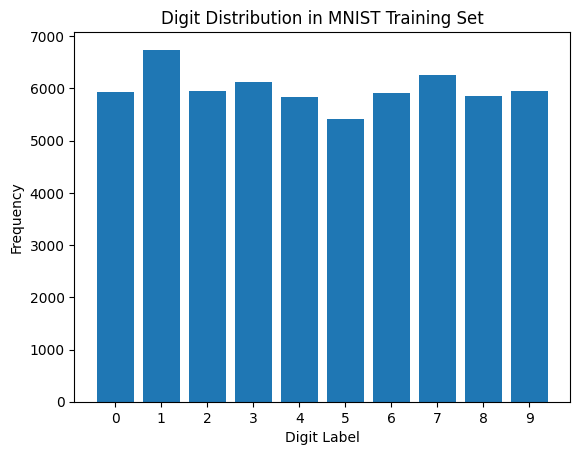

In [133]:
labels, counts = torch.unique(train_dataset.targets, return_counts=True)
plt.bar(labels.tolist(), counts.tolist())
plt.xlabel('Digit Label')
plt.ylabel('Frequency')
plt.title('Digit Distribution in MNIST Training Set')
# Set x-ticks to show each digit label (0 through 9)
plt.xticks(range(10))
plt.show()

## 2. Train a CNN

### Libraries

In [134]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F

### Load the MINST dataset

In [135]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

### Define the network

In [136]:
class FlexibleNetwork(nn.Module):
    def __init__(self, conv_layers, fc_layers, dropout_rate=0.0):
        super(FlexibleNetwork, self).__init__()
        layers = []
        in_channels = 1
        self.relu = nn.ReLU()
        
        # Define the convolutional layers
        for out_channels in conv_layers:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
            layers.append(self.relu)
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            in_channels = out_channels
        self.conv_layers = nn.Sequential(*layers)
        
        # Calculate the size of the tensor after passing through the conv layers
        with torch.no_grad():
            sample_input = torch.randn(1, 1, 28, 28)  # create a random sample input tensor
            conv_output = self.conv_layers(sample_input)  # pass the sample input tensor through the conv layers
            fc_input_size = conv_output.numel()  # calculate the number of elements in the tensor
        
        # Define the fully connected layers dynamically based on fc_layers
        fc_layers_list = []
        input_size = fc_input_size
        for output_size in fc_layers:
            fc_layers_list.append(nn.Linear(input_size, output_size))
            fc_layers_list.append(self.relu)
            fc_layers_list.append(nn.Dropout(dropout_rate))
            input_size = output_size
        
        # Sequential container for fully connected layers
        self.fc_layers = nn.Sequential(*fc_layers_list)
        
        # Output layer
        self.output_layer = nn.Linear(input_size, 10)  # final output layer for 10 classes
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor for the fully connected layers
        x = self.fc_layers(x)
        x = self.output_layer(x)
        return x


### Train the model function

In [137]:
def train_model(label='Training', conv_layers=None, fc_layers=None, dropout_rate=0.5, optimizer_type='Adam', reg_type='None', reg_lambda=0.0, momentum=None, n_epochs=5):
    model = FlexibleNetwork(conv_layers, fc_layers, dropout_rate=dropout_rate)
    criterion = nn.CrossEntropyLoss()

    # Select optimizer
    if optimizer_type == 'SGD':
        if momentum is not None and momentum > 0:
            optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=momentum)
        else:
            optimizer = optim.SGD(model.parameters(), lr=0.01)  # SGD without momentum
    elif optimizer_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.01)
    else:
        raise ValueError("Unsupported optimizer type")

    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    print(f"\nExperiment: {label}")
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        correct = 0  # Initialize correct count for training accuracy
        total = 0    # Initialize total count for training accuracy
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Apply regularization if specified
            if reg_type == 'L1':
                l1_norm = sum(param.abs().sum() for param in model.parameters())  # L1 norm of all parameters
                loss += reg_lambda * l1_norm  # add L1 regularization to loss
            elif reg_type == 'L2':
                l2_norm = sum(param.pow(2).sum() for param in model.parameters())  # L2 norm of all parameters
                loss += reg_lambda * l2_norm  # add L2 regularization to loss
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_losses.append(train_loss / len(train_loader))
        train_accuracy = 100 * correct / total if total > 0 else 0  # Avoid division by zero
        train_accuracies.append(train_accuracy)

        # Evaluation on test set
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        test_losses.append(test_loss / len(test_loader))
        test_accuracy = 100 * correct / total
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_losses[-1]:.4f} (acc. {train_accuracy:.2f}%) | Test Loss: {test_losses[-1]:.4f} (acc. {test_accuracy:.2f}%)")
    
    return train_losses, test_losses

### Default config

In [138]:
default_config = {
    "conv_layers": [32, 64],
    "fc_layers": [128],
    "dropout_rate": 0.0,
    "optimizer_type": "Adam",
    "momentum": None,
    "reg_type": "None",
    "reg_lambda": 0.001,
    "n_epochs": 5,
    "label": "Default Experiment"
}

### Result handler

In [139]:
def result_handler(experiment_configs):
    results = {}
    for config in experiment_configs:
        label = config["label"]
        train_losses, test_losses = train_model(
            label=label,
            conv_layers=config["conv_layers"],
            fc_layers=config["fc_layers"],
            dropout_rate=config["dropout_rate"],
            optimizer_type=config["optimizer_type"],
            momentum=config["momentum"],
            reg_type=config["reg_type"],
            reg_lambda=config["reg_lambda"],
            n_epochs=config["n_epochs"]
        )
        results[label] = {
            "train_losses": train_losses,
            "test_losses": test_losses
        }
    return results

### Plot handler

In [140]:
def plot_handler(results, experiment_configs):
    num_experiments = len(experiment_configs)
    fig, axs = plt.subplots(1, num_experiments, figsize=(5 * num_experiments, 5), sharey=False)
    epochs = range(1, default_config["n_epochs"] + 1)
    
    for i, (label, data) in enumerate(results.items()):
        axs[i].plot(epochs, data["train_losses"], marker='o', label="Train Loss")
        axs[i].plot(epochs, data["test_losses"], marker='o', linestyle='--', label="Test Loss")
        axs[i].set_title(label)
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel('Metric')
        axs[i].legend()
    
    plt.tight_layout()
    plt.show()

### 1. Conv layers


Experiment: 1 Conv Layers (8)
Epoch 1/5 | Train Loss: 0.2139 (acc. 93.98%) | Test Loss: 0.1228 (acc. 96.17%)
Epoch 2/5 | Train Loss: 0.0711 (acc. 97.79%) | Test Loss: 0.0632 (acc. 97.92%)
Epoch 3/5 | Train Loss: 0.0551 (acc. 98.25%) | Test Loss: 0.0606 (acc. 98.13%)
Epoch 4/5 | Train Loss: 0.0463 (acc. 98.59%) | Test Loss: 0.0624 (acc. 98.04%)
Epoch 5/5 | Train Loss: 0.0420 (acc. 98.69%) | Test Loss: 0.0703 (acc. 98.11%)

Experiment: 1 Conv Layers (16)
Epoch 1/5 | Train Loss: 0.1817 (acc. 94.83%) | Test Loss: 0.0744 (acc. 97.63%)
Epoch 2/5 | Train Loss: 0.0631 (acc. 98.08%) | Test Loss: 0.0786 (acc. 97.45%)
Epoch 3/5 | Train Loss: 0.0483 (acc. 98.48%) | Test Loss: 0.0832 (acc. 97.72%)
Epoch 4/5 | Train Loss: 0.0431 (acc. 98.69%) | Test Loss: 0.0741 (acc. 98.06%)
Epoch 5/5 | Train Loss: 0.0406 (acc. 98.79%) | Test Loss: 0.0691 (acc. 98.35%)

Experiment: 1 Conv Layers (32)
Epoch 1/5 | Train Loss: 0.2355 (acc. 94.11%) | Test Loss: 0.0760 (acc. 97.54%)
Epoch 2/5 | Train Loss: 0.0677 (acc.

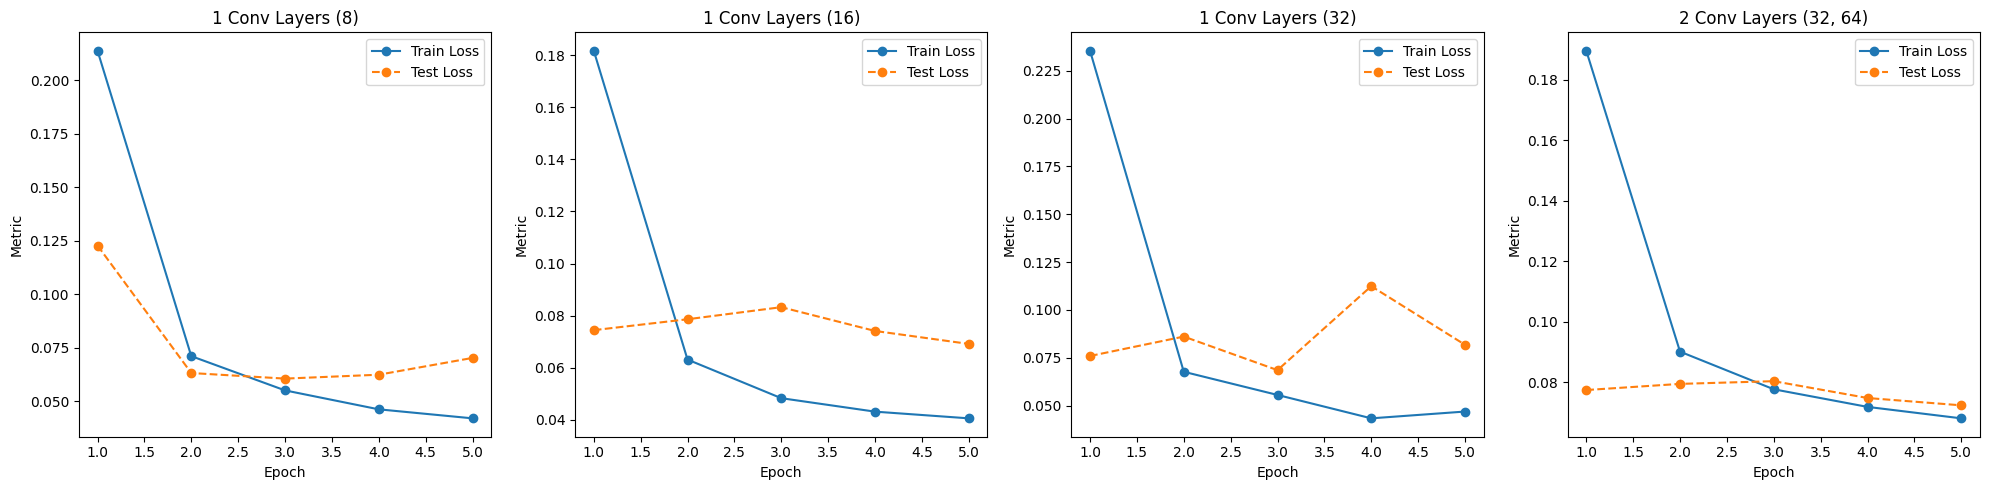

In [142]:
conv_layer_configs = [
    {**default_config, "conv_layers": [8], "label": "1 Conv Layers (8)"},
    {**default_config, "conv_layers": [16], "label": "1 Conv Layers (16)"},
    {**default_config, "conv_layers": [32], "label": "1 Conv Layers (32)"},
    {**default_config, "conv_layers": [32, 64], "label": "2 Conv Layers (32, 64)"},
]
conv_results = result_handler(conv_layer_configs)
plot_handler(conv_results, conv_layer_configs)

### 2. Fully layers


Experiment: 1 Conv=16, FC=64
Epoch 1/5 | Train Loss: 0.1778 (acc. 94.75%) | Test Loss: 0.0645 (acc. 98.01%)
Epoch 2/5 | Train Loss: 0.0675 (acc. 97.94%) | Test Loss: 0.0651 (acc. 98.09%)
Epoch 3/5 | Train Loss: 0.0547 (acc. 98.36%) | Test Loss: 0.1203 (acc. 96.65%)
Epoch 4/5 | Train Loss: 0.0456 (acc. 98.57%) | Test Loss: 0.0993 (acc. 97.39%)
Epoch 5/5 | Train Loss: 0.0411 (acc. 98.72%) | Test Loss: 0.0793 (acc. 98.18%)

Experiment: 1 Conv=16, FC=256
Epoch 1/5 | Train Loss: 0.2176 (acc. 94.41%) | Test Loss: 0.0680 (acc. 97.94%)
Epoch 2/5 | Train Loss: 0.0596 (acc. 98.14%) | Test Loss: 0.0732 (acc. 97.95%)
Epoch 3/5 | Train Loss: 0.0482 (acc. 98.53%) | Test Loss: 0.0923 (acc. 97.56%)
Epoch 4/5 | Train Loss: 0.0413 (acc. 98.73%) | Test Loss: 0.0902 (acc. 97.96%)
Epoch 5/5 | Train Loss: 0.0456 (acc. 98.70%) | Test Loss: 0.1288 (acc. 97.44%)


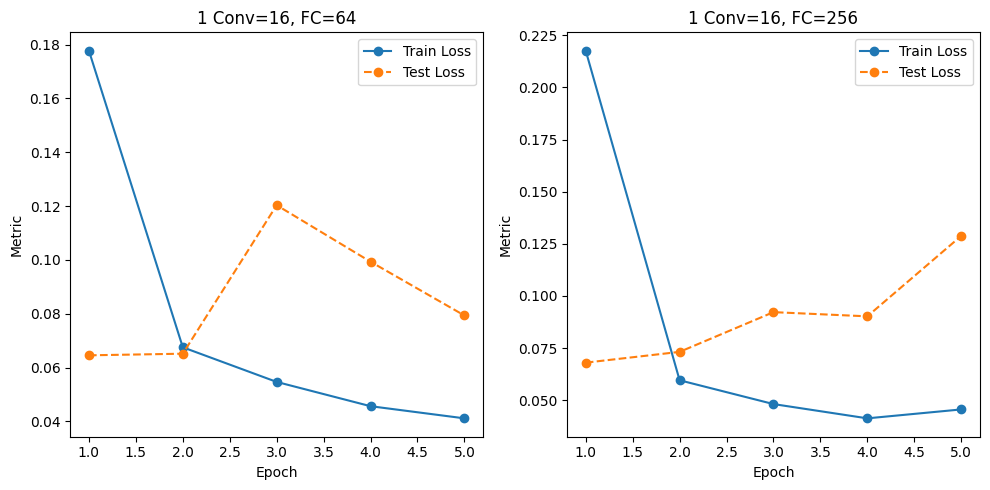

In [125]:
fc_layer_configs = [
    {**default_config, "conv_layers": [16], "fc_layer": 64, "label": "1 Conv=16, FC=64"},
    {**default_config, "conv_layers": [16], "fc_layer": 128, "label": "1 Conv=16, FC=128"},
    {**default_config, "conv_layers": [16], "fc_layer": 256, "label": "1 Conv=16, FC=256"},
]
fc_results = result_handler(fc_layer_configs)
plot_handler(fc_results, fc_layer_configs)

No big influence on the results

### 1. Regularization


Experiment: Default
Epoch 1/5 | Train Loss: 0.1849 (acc. 94.23%) | Test Loss: 0.0671 (acc. 97.89%)
Epoch 2/5 | Train Loss: 0.0893 (acc. 97.30%) | Test Loss: 0.1109 (acc. 96.38%)
Epoch 3/5 | Train Loss: 0.0786 (acc. 97.60%) | Test Loss: 0.0815 (acc. 97.44%)
Epoch 4/5 | Train Loss: 0.0730 (acc. 97.81%) | Test Loss: 0.0744 (acc. 97.80%)
Epoch 5/5 | Train Loss: 0.0701 (acc. 97.90%) | Test Loss: 0.0796 (acc. 97.78%)

Experiment: L1(0.002)
Epoch 1/5 | Train Loss: 1.7601 (acc. 87.27%) | Test Loss: 0.1307 (acc. 95.92%)
Epoch 2/5 | Train Loss: 1.3569 (acc. 94.73%) | Test Loss: 0.1300 (acc. 96.09%)
Epoch 3/5 | Train Loss: 1.3266 (acc. 94.98%) | Test Loss: 0.1217 (acc. 96.28%)
Epoch 4/5 | Train Loss: 1.3231 (acc. 95.10%) | Test Loss: 0.1307 (acc. 96.03%)
Epoch 5/5 | Train Loss: 1.3134 (acc. 95.05%) | Test Loss: 0.1144 (acc. 96.57%)

Experiment: L1(0.001)
Epoch 1/5 | Train Loss: 1.0935 (acc. 92.81%) | Test Loss: 0.2092 (acc. 93.32%)
Epoch 2/5 | Train Loss: 0.8280 (acc. 96.16%) | Test Loss: 0.0990

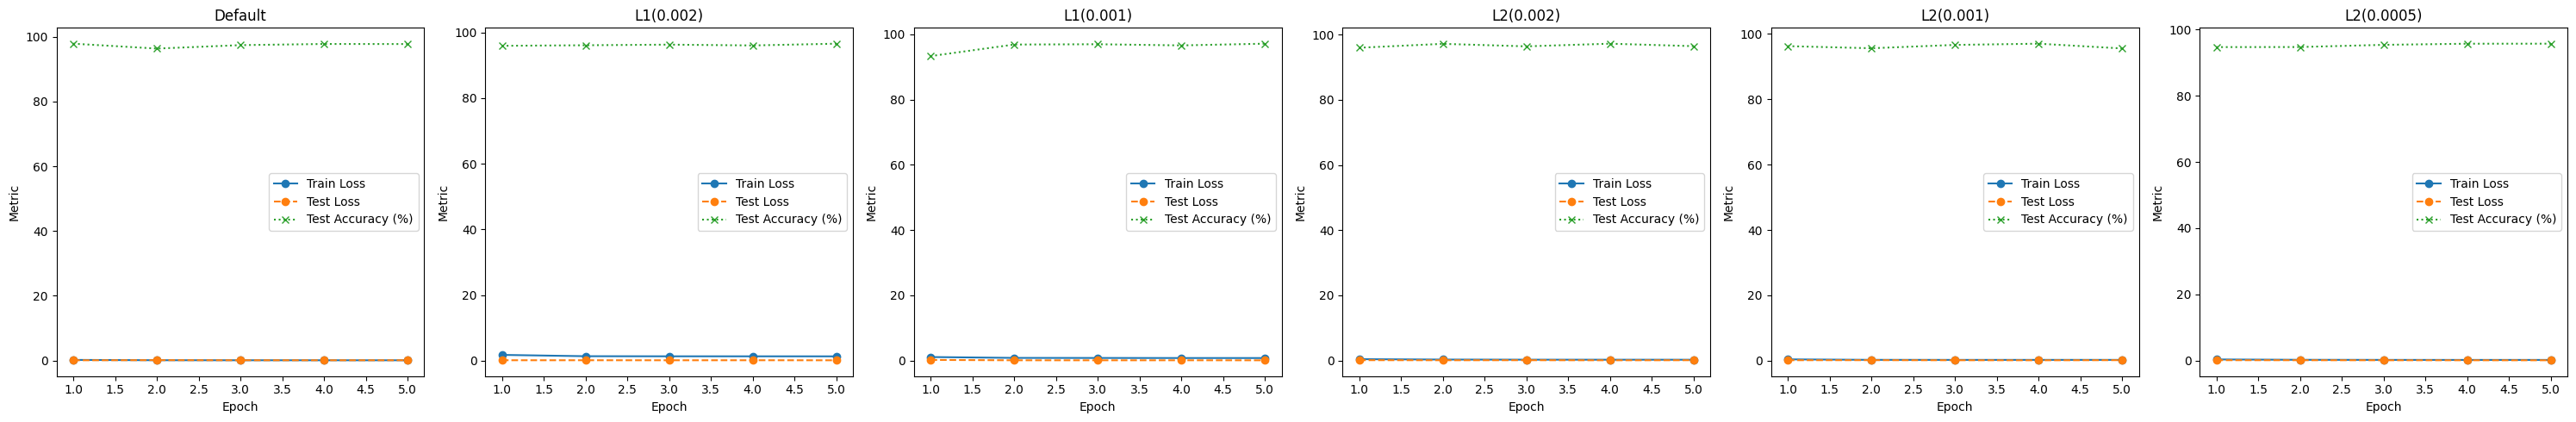

In [57]:
reg_configs = [
    {**default_config, "label": "Default"},
    {**default_config, "reg_type": "L1", "reg_lambda": 0.001, "label": "L1(0.001)"},
    {**default_config, "reg_type": "L1", "reg_lambda": 0.0005, "label": "L1(0.0005)"},
    {**default_config, "reg_type": "L2", "reg_lambda": 0.001, "label": "L2(0.001)"},
    {**default_config, "reg_type": "L2", "reg_lambda": 0.0005, "label": "L2(0.0005)"},
]
reg_results = result_handler(reg_configs)
plot_handler(reg_results, reg_configs)

### 2. Dropout

In [60]:
drop_configs = [
    {**default_config, "dropout_rate": 0.2, "label": "Drop(0.2)"},
    {**default_config, "dropout_rate": 0.4, "label": "Drop(0.4)"},
]

drop_results = result_handler(drop_configs)
plot_handler(drop_results, drop_configs)


Experiment: Drop(0.2)
Epoch 1/5 | Train Loss: 0.2059 (acc. 93.95%) | Test Loss: 0.0839 (acc. 97.46%)
Epoch 2/5 | Train Loss: 0.1033 (acc. 96.91%) | Test Loss: 0.0622 (acc. 98.10%)
Epoch 3/5 | Train Loss: 0.0920 (acc. 97.31%) | Test Loss: 0.0772 (acc. 97.79%)
Epoch 4/5 | Train Loss: 0.0896 (acc. 97.35%) | Test Loss: 0.0778 (acc. 97.87%)
Epoch 5/5 | Train Loss: 0.0876 (acc. 97.48%) | Test Loss: 0.0833 (acc. 97.50%)

Experiment: Drop(0.4)
Epoch 1/5 | Train Loss: 0.4257 (acc. 86.63%) | Test Loss: 0.2174 (acc. 93.14%)
Epoch 2/5 | Train Loss: 0.2780 (acc. 91.59%) | Test Loss: 0.1384 (acc. 95.47%)
Epoch 3/5 | Train Loss: 0.2498 (acc. 92.38%) | Test Loss: 0.1331 (acc. 95.81%)
Epoch 4/5 | Train Loss: 0.2252 (acc. 93.25%) | Test Loss: 0.1454 (acc. 95.28%)
Epoch 5/5 | Train Loss: 0.2290 (acc. 92.96%) | Test Loss: 0.1448 (acc. 95.85%)

Experiment: Drop(0.6)


KeyboardInterrupt: 

### 3. Momentum

In [ ]:
mom_configs = [
    {**default_config, "optimizer_type": "SGD", "label": "SGD"},
    {**default_config, "optimizer_type": "SGD", "momentum": 0.3, "label": "SGD(0.3)"},
    {**default_config, "optimizer_type": "SGD", "momentum": 0.6, "label": "SGD(0.6)"},
    {**default_config, "optimizer_type": "SGD", "momentum": 0.9, "label": "SGD(0.9)"}
]

mom_results = result_handler(mom_configs)
plot_handler(mom_results, mom_configs)